## Section1 如何用Alphalens计算IC值？

## 目录
1. Alphalen是什么？
2. 如何编写Alpha因子？
3. Alphalens需要什么数据格式？
4. 如何计算不同Quantiles收益与标准差？
5. 如何将不同收益曲线可视化？
6. 什么是信息系数？

## Alphalen是什么？
Alphalens是一个Python库，专门做股票的alpha(α)绩效分析预测。

下载方式： pip install alphalens

官方网站： http://quantopian.github.io/alphalens/index.html

## 如何编写Alpha因子？
1. 编制函数需要的算法，调用talib计算momentum
2. 定义计算alpha值的类
3. 编制因子的函数，并返回因子DataFrame
4. 传入股票数据（Panel）
5. 输出Factor数据

In [1]:
import talib as ta
import numpy as np
import pandas as pd

# 1. 编制函数需要的算法，调用talib计算momentum
def momentum(df, period=2):
    return pd.DataFrame(
        {name: ta.ROCR(item.values, period) 
         for name, item in df.iteritems()},
         index=df.index
        )

# 2. 定义计算alpha值的类
class alphas(object):
    def __init__(self, pn_data):
        if pn_data.isnull().values.any():
            pn_data.fillna(method='ffill',inplace=True)
        self.close = pd.DataFrame(pn_data.minor_xs('close'), 
                                  dtype=np.float64)

# 3. 编制因子的函数，并返回因子DataFrame
    def mom001(self):
        alpha = -1 * momentum(self.close)
        return alpha

In [2]:
# 4. 传入股票数据
if __name__ == '__main__':
    import pandas as pd
    import tushare as ts

    codes = ['000001', '601318', '600029', '000089', '000402', 
             '000895', '600006', '000858', '600036', '600050']
    stocks_dict = {}
    for c in codes:
        stock = ts.get_k_data(c, start='2016-01-01', end='2016-12-31', ktype='D', autype='qfq')
        stock.index = pd.to_datetime(stock['date'], format='%Y-%m-%d')
        stock.pop('date')
        stocks_dict[c] = stock

    pn = pd.Panel(stocks_dict)
    print pn

<class 'pandas.core.panel.Panel'>
Dimensions: 10 (items) x 244 (major_axis) x 6 (minor_axis)
Items axis: 000001 to 601318
Major_axis axis: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
Minor_axis axis: open to code


In [3]:
#5. 输出Factor数据
alpha_mom = alphas(pn).mom001()
print alpha_mom.tail()

              000001    000089    000402    000858    000895    600006  \
date                                                                     
2016-12-26 -0.997812 -0.993865 -1.025082 -0.970079 -0.983686 -0.980716   
2016-12-27 -1.000000 -1.004957 -1.021181 -0.997687 -0.999486 -0.988764   
2016-12-28 -0.993421 -0.983951 -0.978347 -0.987193 -0.995092 -0.973315   
2016-12-29 -1.000000 -0.974106 -0.977399 -0.985733 -1.005353 -0.982955   
2016-12-30 -1.004415 -1.003764 -0.987594 -1.016796 -1.026532 -0.992785   

              600029    600036    600050    601318  
date                                                
2016-12-26 -0.988811 -1.001692 -1.016927 -1.010066  
2016-12-27 -0.985975 -1.006228 -0.966709 -1.015261  
2016-12-28 -0.985856 -0.992660 -0.984635 -1.004841  
2016-12-29 -0.994310 -0.987622 -0.998675 -0.996313  
2016-12-30 -1.007174 -0.998885 -0.950585 -1.003967  


## Alphalens需要什么数据格式？

factor: MultiIndex（用stack()方法来转换）

prices: DataFrame

In [4]:
#转换成MultiIndex
factor = alpha_mom.stack()
print factor.tail()

date              
2016-12-30  600006   -0.992785
            600029   -1.007174
            600036   -0.998885
            600050   -0.950585
            601318   -1.003967
dtype: float64


In [5]:
# 股票池价格的Dataframe
prices = pn.minor_xs('close')
print prices.tail()

           000001 000089  000402  000858  000895 600006 600029  600036 600050  \
date                                                                            
2016-12-26   9.12    8.1  10.299  33.653  19.355   7.12   7.07  17.166   7.81   
2016-12-27   9.08   8.11  10.221  33.643   19.43   7.04   7.03  17.127   7.55   
2016-12-28   9.06   7.97  10.076  33.222   19.26   6.93   6.97   17.04   7.69   
2016-12-29   9.08    7.9    9.99  33.163  19.534   6.92   6.99  16.915   7.54   
2016-12-30    9.1      8   9.951   33.78  19.771   6.88   7.02  17.021   7.31   

           601318  
date               
2016-12-26  35.12  
2016-12-27  35.26  
2016-12-28  35.29  
2016-12-29  35.13  
2016-12-30  35.43  


In [6]:
#输入Alphalen所需要的数据格式
import alphalens

factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor, prices, quantiles=5)
print factor_data.head()

                          1         5        10    factor  factor_quantile
date       asset                                                          
2016-01-06 000001 -0.051136 -0.071104 -0.085895 -1.020375                3
           000089 -0.099563 -0.077824 -0.058657 -1.020746                2
           000402 -0.098205 -0.116052 -0.080460 -1.027879                2
           000858 -0.048892 -0.092910 -0.074124 -1.034225                1
           000895 -0.039744 -0.094613 -0.114192 -1.029014                1


## 如何不同Quantiles期望收益与标准差？

In [7]:
mean_return_by_q, std_err_by_q = alphalens.performance.mean_return_by_quantile(factor_data, by_date=True)
print(mean_return_by_q).head()
print(std_err_by_q).head()

                                  1         5         10
factor_quantile date                                    
1               2016-01-06  0.019360  0.001483  0.006281
                2016-01-07  0.002709  0.019796  0.016846
                2016-01-08  0.029033 -0.011362  0.001485
                2016-01-11  0.011741 -0.006216  0.008437
                2016-01-12  0.002170 -0.020541 -0.023274
                                  1         5         10
factor_quantile date                                    
1               2016-01-06  0.004574  0.000851  0.020034
                2016-01-07  0.021980  0.052229  0.054293
                2016-01-08  0.029248  0.012479  0.048253
                2016-01-11  0.015864  0.035106  0.030001
                2016-01-12  0.021096  0.049757  0.033327


## 如何将不同收益曲线可视化？
1. 持有不同天数的收益曲线
2. 累积收益曲线

D:\ProgramData\Anaconda2\lib\site-packages\alphalens\plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,min_periods=1,window=5).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
D:\ProgramData\Anaconda2\lib\site-packages\alphalens\plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,min_periods=1,window=10).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))


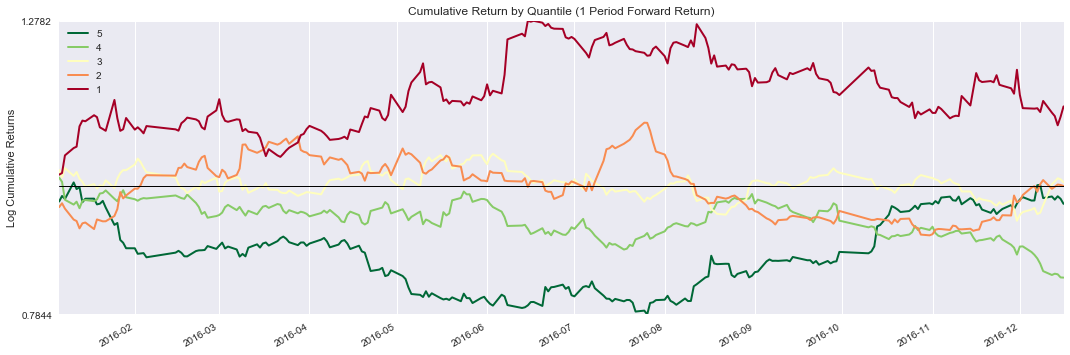

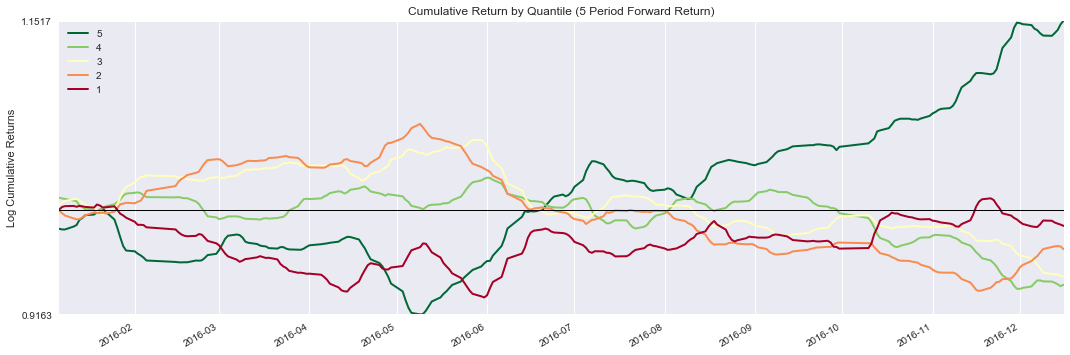

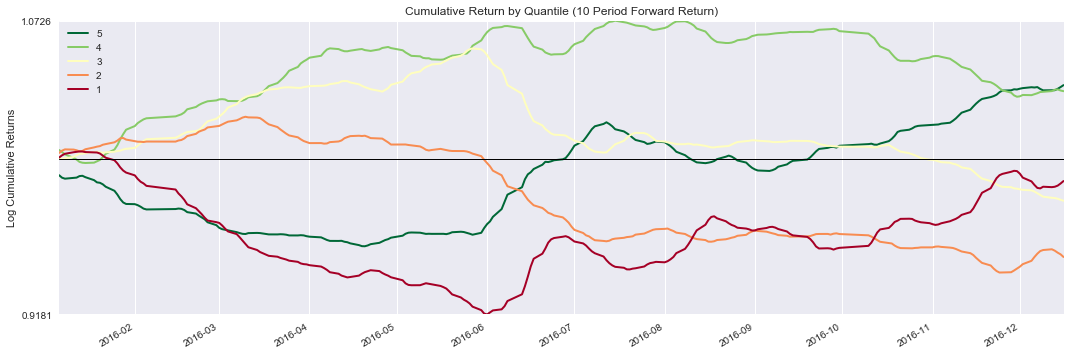

In [8]:
import matplotlib.pyplot as plt

alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 1)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 5)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 10)
plt.show()

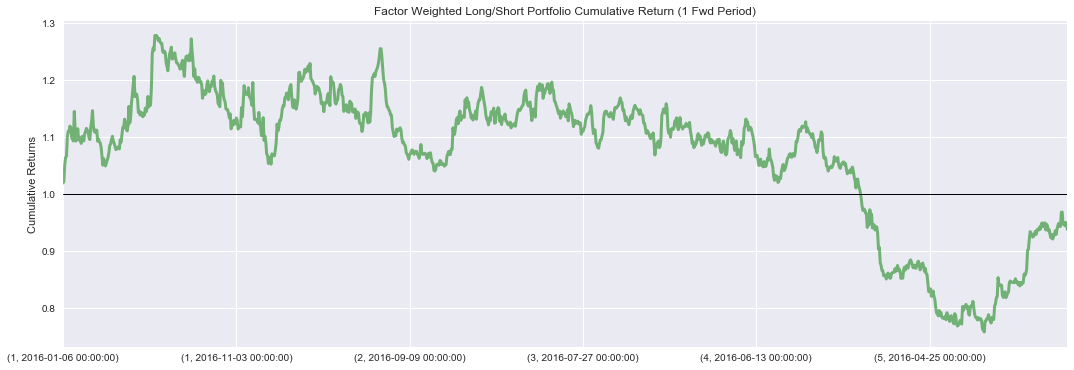

In [9]:
alphalens.plotting.plot_cumulative_returns(mean_return_by_q.iloc[:,0], period=1)
plt.show()

## 什么是信息系数？
度量变量的预测值与实际值之间的关系的相关值。信息系数是用来评估金融分析师预测技能的一种表现方法。

系数在-1到1之间，越大表示正相关程度强。标准是mean(IC)>0.02

### 什么是spearman相关系数？
$P_s = 1- \frac {6\sum d_i^2}{n(n^2-1)}$

其中d为秩次差。

因此IC值是代表因子排序与收益排序的相关性。

### 什么是秩次差？
A = [1,3,5,7,9]
B = [3,2,4,5,1]

A的排序是1,2,3,4,5

B的排序是3,2,4,5,1

d为排序相减

$d^2 = 4,0,1,1,16$

$P_s = 1-\frac{6*22}{5(25-1)} = -0.1$

IC值例子


                  1         5         10
date                                    
2016-01-06 -0.163636 -0.163636 -0.527273
2016-01-07  0.042424  0.151515  0.127273
2016-01-08 -0.418182  0.115152  0.030303
2016-01-11  0.151515  0.296970  0.187879
2016-01-12 -0.139394 -0.066667  0.175758
2016-01-13 -0.163636 -0.612121  0.430303
2016-01-14 -0.272727 -0.042424 -0.272727
2016-01-15  0.454545  0.466667 -0.309091
2016-01-18 -0.127273  0.200000 -0.333333
2016-01-19 -0.078788 -0.078788  0.357576
2016-01-20  0.466667  0.393939  0.321212
2016-01-21  0.490909 -0.018182  0.163636
2016-01-22 -0.309091 -0.527273 -0.187879
2016-01-25 -0.587879 -0.551515 -0.212121
2016-01-26  0.321212  0.236364  0.284848
2016-01-27 -0.163636  0.272727  0.515152
2016-01-28 -0.018182  0.042424  0.066667
2016-01-29 -0.624242  0.090909 -0.018182
2016-02-01  0.248485 -0.090909 -0.054545
2016-02-02 -0.684848 -0.272727  0.115152
2016-02-03  0.224242 -0.321212 -0.357576
2016-02-04 -0.200000 -0.563636 -0.369697
2016-02-05 -0.26

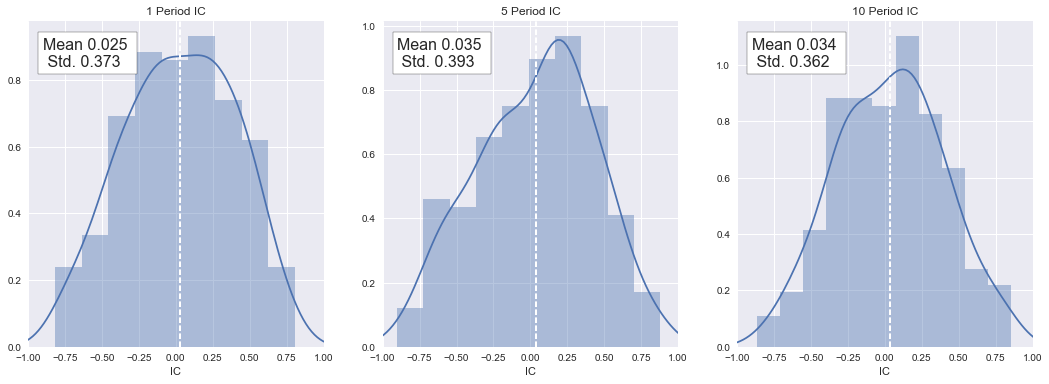

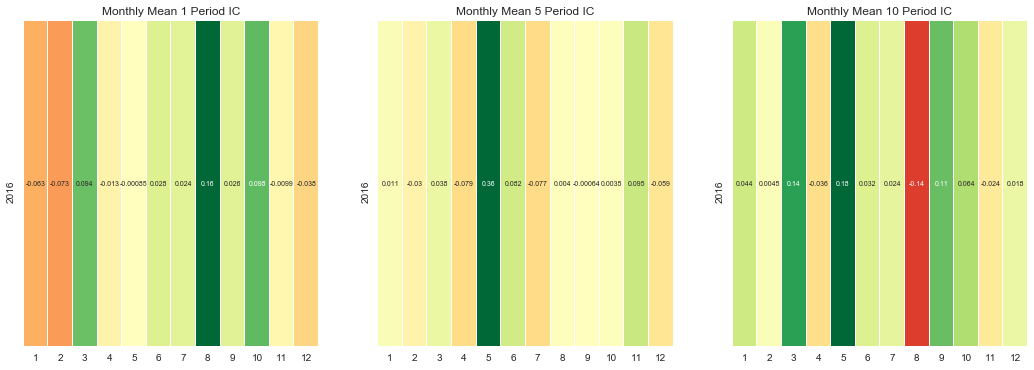

In [11]:
ic = alphalens.performance.factor_information_coefficient(factor_data)
print ic
alphalens.plotting.plot_ic_hist(ic)
mean_monthly_ic = alphalens.performance.mean_information_coefficient(factor_data, by_time='M')
# print mean_monthly_ic.mean()
alphalens.plotting.plot_monthly_ic_heatmap(mean_monthly_ic)
plt.show()

## 作业
试用alphalens不同的功能。